In [ ]:
import folium
import pandas as pd
import webbrowser
import os
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

import ipywidgets as widgets
from IPython.display import display
import re
from nltk.corpus import stopwords
from collections import defaultdict

# 4. Visualizing the Most Relevant Restaurants

### 4.1 To geocode each restaurant we'll use the geopy library.

In [11]:
def geocode_with_postalcode(postal_code):
    
    geolocator = Nominatim(user_agent="my_geocoder")
    
    try:
        # Format the query to specifically look for Italian postal codes
        query = f"{postal_code}, Italia"
        
        # Use structured query with language set to Italian
        location = geolocator.geocode(
            query,
            language='it',
            addressdetails=True,  # This is key - it returns structured address details
            exactly_one=True
        )
        
        if location:
            address = location.raw['address']
            
            # Extract city (try different possible fields)
            city = (
                address.get('city') or
                address.get('town') or
                address.get('village') or
                address.get('municipality')
            )
            
            # Extract region/state
            region = (
                address.get('region') or
                address.get('state')
            )
            
            return {
                'postal_code': postal_code,
                'city': city,
                'region': region,
                'latitude': location.latitude,
                'longitude': location.longitude,
                'full_address': address
            }
            
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Error geocoding {postal_code}: {str(e)}")
        
    return None

def geocode_restaurants(df):
    
    # Create new columns
    df['latitude'] = None
    df['longitude'] = None
    df['city'] = None
    df['region'] = None
    
    # Cache for postal codes to avoid duplicate 
    postcode_cache = {}
    
    # Process each unique postal code
    for postal_code in df['postalCode_clean'].unique():
        if pd.notna(postal_code):
            if postal_code not in postcode_cache:
                result = geocode_with_postalcode(str(postal_code))
                if result:
                    postcode_cache[postal_code] = result
                    time.sleep(1)  # Respect rate limits
    
    # Apply results to DataFrame
    for postal_code, data in postcode_cache.items():
        mask = df['postalCode_clean'] == postal_code
        df.loc[mask, 'latitude'] = data['latitude']
        df.loc[mask, 'longitude'] = data['longitude']
        df.loc[mask, 'city'] = data['city']
        df.loc[mask, 'region'] = data['region']
    
    return df

In [12]:
df = pd.read_csv('merged_output.csv')
df['postalCode_clean'] = df['postalCode'].str.zfill(5)
# Process the data
df_geo = geocode_restaurants(df)
df_geo.to_csv("RestaurantPlusGeo.csv",index=False)
df_geo.head()

,restaurantName,address,city,postalCode,country,priceRange,cuisineType,description,facilitiesServices,creditCards,phoneNumber,website,postalCode_clean,latitude,longitude,region
0,Burro & Alici,lungomare Colombo 98,Fano,61032,Italy,€€,"Seafood, Classic Cuisine",With just a road separating it from the beach ...,['Terrace'],"['Amex', 'Mastercard', 'Visa']",+39 0721 961200,https://www.ristoranteburroealici.it/,61032,43.841586,13.017892,Marche
1,Oishi,via Mario Capuani 47,Teramo,64100,Italy,€€,"Japanese, Fusion",East meets West in this attractive restaurant ...,"['Air conditioning', 'Counter dining', 'Terrace']","['Amex', 'Unionpay', 'Dinersclub', 'Discover',...",+39 391 394 2429,https://www.oishiteramo.it/,64100,42.666074,13.717226,Abruzzo
2,Uliassi,banchina di Levante 6,Senigallia,60019,Italy,€€€€,"Creative, Seafood","The Adriatic Riviera, a perfect picture-postca...","['Air conditioning', 'Great view', 'Interestin...","['Amex', 'Dinersclub', 'Mastercard', 'Visa']",+39 071 65463,http://www.uliassi.com,60019,43.677375,13.210571,Marche
3,Oberlechner,località Velloi 7,Lagundo,39022,Italy,€€,"Regional Cuisine, Classic Cuisine",From Merano you climb to an altitude of 1 000m...,"['Car park', 'Garden or park', 'Great view', '...","['Mastercard', 'Visa']",+39 0473 448350,https://www.gasthofoberlechner.com,39022,46.694686,11.10515,Trentino-Alto Adige
4,Ai Gondolieri,fondamenta de l'Ospedaleto,Venezia,Venice,30123,€€€,"Venetian, Traditional Cuisine","Situated behind the Guggenheim museum, this ru...",['Air conditioning'],"['Amex', 'Maestrocard', 'Mastercard', 'Visa']",+39 041 528 6396,https://aigondolieri.it/?lang=it,Venice,45.437191,12.33459,Veneto


## 4.3 & 4.4 Represents the restaurants on a map.

In [17]:
# I remove the restaurants for which I cannot retrieve the latitude and longitude.
df_geo=pd.read_csv('RestaurantPlusGeo.csv')
print(f"Lat null: {df['latitude'].isnull().sum()} \nLong null: {df['longitude'].isnull().sum()}")
df_geo = df.dropna(subset=['latitude', 'longitude'])

Lat null: 3 
Long null: 3


In [14]:
# Here we are creating a map that represents the location of all the restaurants listed in the dataset, saving it as an HTML file, and opening it to display to the user.
map = folium.Map(location=[41.9028, 12.4964], zoom_start=6)

for index, row in df_geo.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['restaurantName']}<br>{row['address']}<br>{row['city']}<br>{row['region']}",
        tooltip=row['restaurantName']
    ).add_to(map)

map.fit_bounds([[35.5, 6.6], [47.1, 18.8]])
file_path = 'restaurant_map.html'
map.save(file_path)
webbrowser.open('file://' + os.path.realpath(file_path))


True

### Below is the result: an interactive map displaying all the restaurants. Users can zoom in and view the name and address of each restaurant. The map will be saved as a file named `restaurant_map.html`.

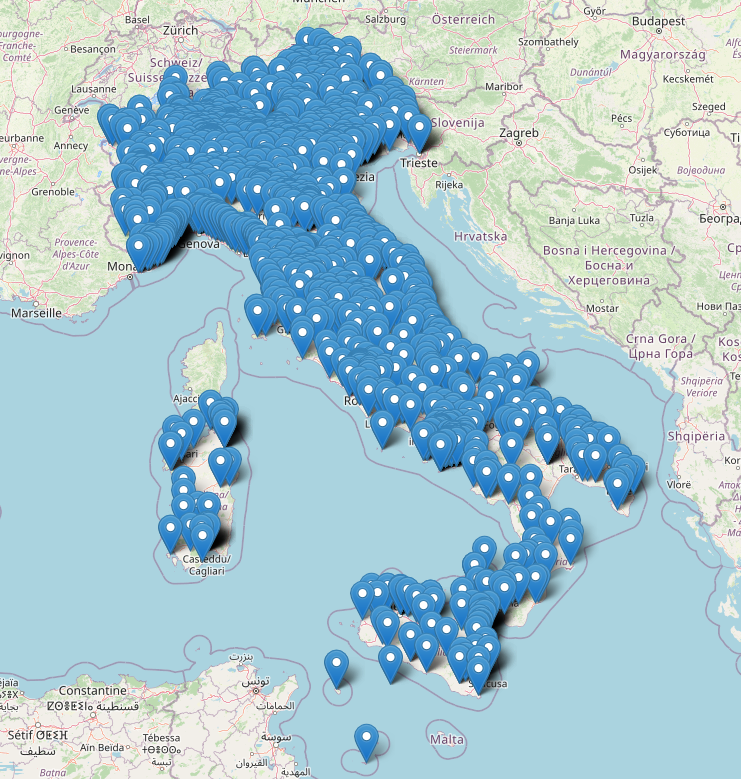

In [ ]:
# We represent the Italian regions with a red scale indicating the average cost of restaurants per region.

#from branca.element import Template, MacroElement

mapping_price = {'€': 1, '€€': 2, '€€€': 3, '€€€€': 4}
df_geo['price_numeric'] = df_geo['priceRange'].map(mapping_price)

# mean price for region
avg_price_by_region = df_geo.groupby('region')['price_numeric'].mean().reset_index()

# For the representation: A folder was downloaded from the INPS website to define the regional boundaries.
regioni = gpd.read_file('Reg01012024/Reg01012024_WGS84.shp') 

regioni = regioni.merge(avg_price_by_region, left_on='DEN_REG', right_on='region')

# Create map on Italy
mappa = folium.Map(location=[41.9028, 12.4964], zoom_start=6)

# Add the choropleth layer
folium.Choropleth(
    geo_data=regioni,
    name='choropleth',
    data=regioni,
    columns=['DEN_REG', 'price_numeric'],
    key_on='feature.properties.DEN_REG',
    fill_color='Reds',
    fill_opacity=1,
    line_opacity=0.2,
    legend_name=None 
).add_to(mappa)

# Personalized Legend
legend_html = '''
<div style="
    position: fixed; 
    top: 15px; right: 10px; 
    width: 430px; height: 93px; 
    background-color: white;
    border: 2px solid grey; 
    box-shadow: 2px 2px 6px rgba(0, 0, 0, 0.3);
    z-index:9999; 
    font-size:14px;
    padding: 10px;
    border-radius: 8px;
">
    <h4 style="margin:0; text-align:center; font-size:18px; font-family: Arial, sans-serif;">Price Restaurant</h4>
    <div style="margin-top: 8px;">
        <div style="background:linear-gradient(to right, #fee5d9, #fcae91, #fb6a4a, #cb181d); height: 20px; border-radius: 5px;"></div>
        <div style="display: flex; justify-content: space-between; font-size: 14px; margin-top: 5px; font-family: Arial, sans-serif;">
            <span>€</span>
            <span>€€€€</span>
        </div>
    </div>
</div>
'''
mappa.get_root().html.add_child(folium.Element(legend_html))

# Save and open the map
file_path = 'map_price_for_region.html'
mappa.save(file_path)
webbrowser.open('file://' + os.path.realpath(file_path))


### Below is the resulting map, where the regions are highlighted based on the cost of their restaurants. The map will be saved as a file named `map_price_for_region.html`.

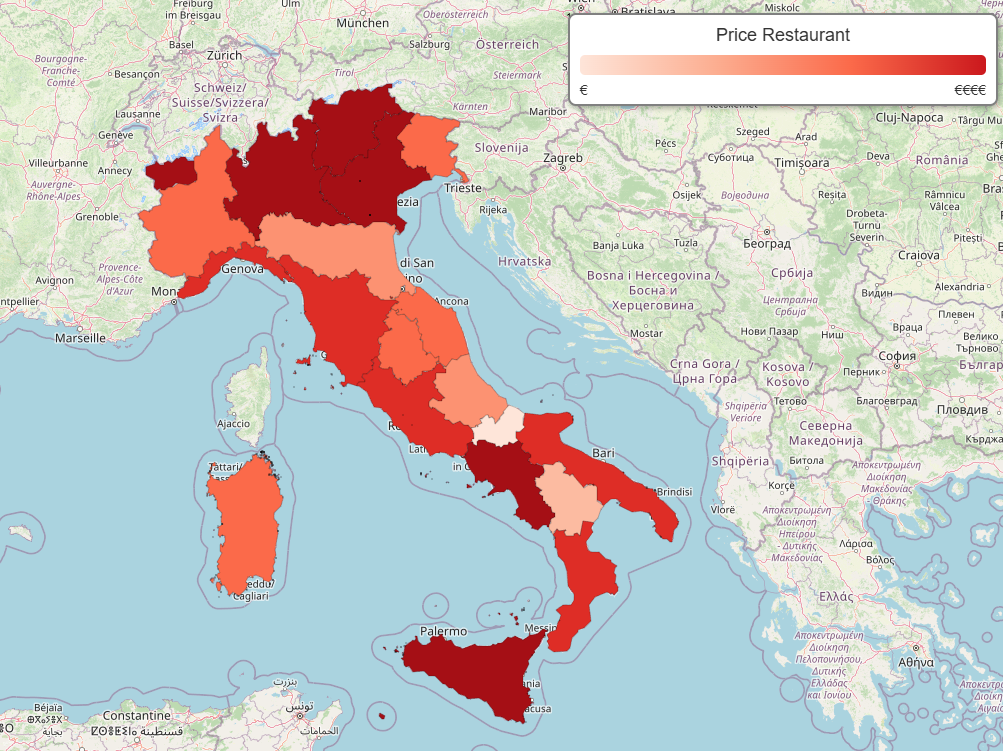

In [16]:
#Wanna visualize only first K restaurant by score obtained in RQ3
df_geo_sorted = df_geo.sort_values(by='postalCode').head(20)#change postalCode with score after exercise 3

map = folium.Map(location=[41.9028, 12.4964], zoom_start=6)

for index, row in df_geo_sorted.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['restaurantName']}<br>{row['address']}<br>{row['city']}<br>{row['region']}",
        tooltip=row['restaurantName']
    ).add_to(map)

map.fit_bounds([[35.5, 6.6], [47.1, 18.8]])
file_path = 'Top_restaurant_map.html'
map.save(file_path)
webbrowser.open('file://' + os.path.realpath(file_path))


True

# 5. BONUS: Advanced Search Engine

This section implements an advanced search engine that allows users to query a dataset of restaurants using multiple filters. The system combines text-based search with additional filters such as price range, accepted credit cards, and offered services to deliver highly relevant results.

In [1]:
import ipywidgets as widgets
from IPython.display import display

import pandas as pd
import re
from nltk.corpus import stopwords

from collections import defaultdict

The following cell defines the **`UserInputInterface`** class, designed to create an interactive user interface using **ipywidgets**. The goal is to allow users to specify advanced search criteria for restaurants.

Users can specify search terms for the following features (some or all):
- **restaurantName**
- **city**
- **cuisineType**

The other tabs are for filtering by:
- **price range**
- **Region**
- **Accepted credit cards**
- **Offered services**

In [2]:
class UserInputInterface:
    def __init__(self):

        layout_with_description = widgets.Layout(width='50%')
        label_layout = widgets.Layout(description_width='150px')
        
        self.restaurant_name = widgets.Text(placeholder='Name of restaurant', description='Restaurant:')
        self.city = widgets.Text(placeholder='City', description='City:')
        self.cuisine_type = widgets.Text(placeholder='Cucine type', description='Cucine:')

        price_options = {
            '€': 1,
            '€€': 2,
            '€€€': 3,
            '€€€€': 4
        }

        self.price_range = widgets.SelectionRangeSlider(
            options=list(price_options.keys()),
            index=(0, 3),
            description='Price:',
            continuous_update=False
        )

        self.regions = widgets.SelectMultiple(
            options=['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 
                     'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 
                     'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 
                     'Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta', 'Veneto'],
            description='Region:',
            rows=7
        )

        credit_card_options = ['Amex', 'Dinersclub', 'Mastercard', 'Visa', 'Discover', 'JCB', 'Unionpay', 'Maestro', 'CartaSi']
        self.credit_card_checkboxes = [widgets.Checkbox(value=False, description=card) for card in credit_card_options]

        self.credit_cards_grid = widgets.GridBox(
            children=self.credit_card_checkboxes,
            layout=widgets.Layout(grid_template_columns="repeat(3, 1fr)", gap="10px")
        )

        self.facilities = widgets.SelectMultiple(
            options=['Air conditioning', 'Interesting wine list', 'Wheelchair access', 'Terrace', 'Counter dining',
                     'Great view', 'Garden or park', 'Car park', 'Restaurant offering vegetarian menus', 'Brunch','Valet parking'],
            description='Services:',
            rows=11,
            layout=widgets.Layout(width='400px')
        )

        self.output = widgets.Output()
        self.search_button = widgets.Button(description="Start Search")
        self.search_button.on_click(self.on_search_button_clicked)
    
    def display(self):
        tab = widgets.Tab()
        tab_contents = [
            widgets.VBox([self.restaurant_name, self.city, self.cuisine_type]),
            widgets.VBox([self.price_range]),
            widgets.VBox([self.regions]),
            widgets.VBox([self.credit_cards_grid]),
            widgets.VBox([self.facilities])
        ]
        tab.children = tab_contents
        tab.set_title(0, 'General Criteria')
        tab.set_title(1, 'Price')
        tab.set_title(2, 'Region')
        tab.set_title(3, 'Accepted Cards')
        tab.set_title(4, 'Offered Services')

        display(tab, self.search_button, self.output)

    def get_values(self):
        return {
            'restaurantName': self.restaurant_name.value,
            'city': self.city.value,
            'cuisineType': self.cuisine_type.value,
            'priceRange': self.price_range.value,
            'regions': list(self.regions.value),
            'creditCards': [checkbox.description for checkbox in self.credit_card_checkboxes if checkbox.value],
            'facilities': list(self.facilities.value)
        }

    def on_search_button_clicked(self, b):
        with self.output:
            self.output.clear_output()
            values = self.get_values()
            print("Collected Values:")
            for key, value in values.items():
                print(f"{key}: {value}")

The following cell performs **pre-processing** on the restaurant dataset:

- **Stopwords**: Defines and combines Italian and English stopwords.
- **Cleaning Functions**:
  - **`clean_text_with_stopwords`**: Cleans text by removing stopwords and special characters.
  - **`clean_text_basic`**: Cleans text while keeping all words (used for the `city` field).
- **Cleaning Application**:
  - Creates normalized (`_clean`) versions of the `restaurantName`, `cuisineType`, and `city` fields.
- **Decoding**: Converts `facilitiesServices` and `creditCards` fields into Python lists.
- **Output**: Displays a preview of the pre-processed DataFrame.


In [ ]:
# Italian and English stopwords
stopwords_italian = set([
    'il', 'lo', 'la', 'i', 'gli', 'le', 'un', 'una', 'del', 'della', 'dello',
    'dei', 'di', 'a', 'ai', 'al', 'allo', 'alle', 'degli', 'd', 'da', 'dal',
    'dallo', 'in', 'nel', 'nello', 'su', 'sul', 'sullo', 'con', 'per', 'tra',
    'fra', 'e'
])
stopwords_english = set(stopwords.words('english'))
stopwords_combined = stopwords_italian.union(stopwords_english)

# Removing stopwords
def clean_text_with_stopwords(text):
    if pd.isna(text):
        return ''
    text = text.lower().strip()
    text = re.sub(r"[^\w\s']", '', text) 
    words = text.split()
    words = [word for word in words if word not in stopwords_combined]  
    return ' '.join(words)

# Basic clean without removing stopwords
def clean_text_basic(text):
    if pd.isna(text):
        return ''
    return text.strip().lower()

df_geo.loc[:,'restaurantName_clean'] = df_geo['restaurantName'].apply(clean_text_with_stopwords)
df_geo.loc[:,'cuisineType_clean'] = df_geo['cuisineType'].apply(clean_text_with_stopwords)
# For the city field, we do not remove stopwords but apply basic cleaning, as removing them could affect the meaning of the city name.
df_geo.loc[:,'city_clean'] = df_geo['city'].apply(clean_text_basic)

df_geo.loc[:,'facilitiesServices_clean'] = df_geo['facilitiesServices'].apply(lambda x: eval(x) if pd.notna(x) else [])
df_geo.loc[:,'creditCards_clean'] = df_geo['creditCards'].apply(lambda x: eval(x) if pd.notna(x) else [])

print("Pre_processed data:")
display(df_geo[['restaurantName','restaurantName_clean', 'city','city_clean', 'cuisineType','cuisineType_clean', 'facilitiesServices','facilitiesServices_clean', 'creditCards','creditCards_clean','priceRange','region']].head())


Pre_processed data:


,restaurantName,restaurantName_clean,city,city_clean,cuisineType,cuisineType_clean,facilitiesServices,facilitiesServices_clean,creditCards,creditCards_clean,priceRange,region
0,Burro & Alici,burro alici,Fano,fano,"Seafood, Classic Cuisine",seafood classic cuisine,['Terrace'],[Terrace],"['Amex', 'Mastercard', 'Visa']","[Amex, Mastercard, Visa]",€€,Marche
1,Oishi,oishi,Teramo,teramo,"Japanese, Fusion",japanese fusion,"['Air conditioning', 'Counter dining', 'Terrace']","[Air conditioning, Counter dining, Terrace]","['Amex', 'Unionpay', 'Dinersclub', 'Discover',...","[Amex, Unionpay, Dinersclub, Discover, Jcb, Ma...",€€,Abruzzo
2,Uliassi,uliassi,Senigallia,senigallia,"Creative, Seafood",creative seafood,"['Air conditioning', 'Great view', 'Interestin...","[Air conditioning, Great view, Interesting win...","['Amex', 'Dinersclub', 'Mastercard', 'Visa']","[Amex, Dinersclub, Mastercard, Visa]",€€€€,Marche
3,Oberlechner,oberlechner,Lagundo,lagundo,"Regional Cuisine, Classic Cuisine",regional cuisine classic cuisine,"['Car park', 'Garden or park', 'Great view', '...","[Car park, Garden or park, Great view, Terrace]","['Mastercard', 'Visa']","[Mastercard, Visa]",€€,Trentino-Alto Adige
4,Ai Gondolieri,gondolieri,Venezia,venezia,"Venetian, Traditional Cuisine",venetian traditional cuisine,['Air conditioning'],[Air conditioning],"['Amex', 'Maestrocard', 'Mastercard', 'Visa']","[Amex, Maestrocard, Mastercard, Visa]",€€€,Veneto


In [26]:
# Function to create an inverted index for a specific field
def build_inverted_index(df, column):
    inverted_index = defaultdict(set)  
    for idx, value in df[column].items():
        terms = value.split() 
        for term in terms:
            inverted_index[term].add(idx) 
    return inverted_index

# Creation of inverted indices
restaurant_name_index = build_inverted_index(df_geo, 'restaurantName_clean')
city_index = build_inverted_index(df_geo, 'city_clean')
cuisine_type_index = build_inverted_index(df_geo, 'cuisineType_clean')

The following cell implements the **advanced search**:

- **`search_inverted_indices`**:
  - Searches indexed fields for terms provided by the user.
  - Calculates a score for each result based on term matches.

- **`advanced_search_with_filters`**:
  - Applies the same cleaning process to both user input and indexed fields.
  - Filters raw results using additional criteria: **price range**, **accepted credit cards**, and **offered services**.
  - Sorts and returns the most relevant results.


In [27]:
# Function to search within indexed fields and calculate scores
def search_inverted_indices(query, indices):
    results = defaultdict(int) 

    for field, terms in query.items():
        if field not in indices:
            continue
        for term in terms.split(): 
            if term in indices[field]:
                for idx in indices[field][term]:
                    results[idx] += 1 
    
    return results

def advanced_search_with_filters(user_input, indices, df, top_n=10):
    price_order = {
        '€': 1,
        '€€': 2,
        '€€€': 3,
        '€€€€': 4
    }

    # Apply the same cleaning process used for specific fields in the dataset to the user input as well.
    query = {
        'restaurantName_clean': clean_text_with_stopwords(user_input['restaurantName']),
        'city_clean': clean_text_with_stopwords(user_input['city']),
        'cuisineType_clean': clean_text_with_stopwords(user_input['cuisineType'])
    }

    raw_results = search_inverted_indices(query, indices)

    # Filter the results based on additional criteria such as price, region, accepted credit cards, and offered services.
    filtered_results = []
    for idx, score in raw_results.items():
        row = df.loc[idx]

        # Price filter
        if not (price_order[row['priceRange']] >= price_order[user_input['priceRange'][0]] and
                price_order[row['priceRange']] <= price_order[user_input['priceRange'][1]]):
            continue

        # Cards Filter
        if not all(card in row['creditCards_clean'] for card in user_input['creditCards']):
            continue

        # Services Filter
        if not all(facility in row['facilitiesServices_clean'] for facility in user_input['facilities']):
            continue

        # Region Filter
        if user_input['regions'] and row['region'] not in user_input['regions']:
            continue
        
        
        filtered_results.append((idx, score))

    sorted_results = sorted(filtered_results, key=lambda x: x[1], reverse=True)
    top_results = df.loc[[r[0] for r in sorted_results[:top_n]]]

    return top_results[['restaurantName', 'address', 'cuisineType', 'priceRange', 'website']]


In [29]:
df_geo[df_geo['restaurantName'] == 'La Pergola']

,restaurantName,address,city,postalCode,country,priceRange,cuisineType,description,facilitiesServices,creditCards,...,website,postalCode_clean,latitude,longitude,region,restaurantName_clean,cuisineType_clean,city_clean,facilitiesServices_clean,creditCards_clean
708,La Pergola,via Cadlolo 101,Roma,136,Italy,€€€€,"Mediterranean Cuisine, Contemporary","Following complete refurbishment, the new Perg...","['Air conditioning', 'Car park', 'Great view',...","['Amex', 'Unionpay', 'Dinersclub', 'Discover',...",...,https://romecavalieri.com/it/la-pergola-it/,00136,41.916452,12.443509,Lazio,pergola,mediterranean cuisine contemporary,roma,"[Air conditioning, Car park, Great view, Inter...","[Amex, Unionpay, Dinersclub, Discover, Jcb, Ma..."


In [ ]:
# UI
ui = UserInputInterface()
ui.display()

Button(description='Start Search', style=ButtonStyle())

Output()

In [43]:
#Result
user_input = ui.get_values()
print(user_input)
indices = {
    'restaurantName_clean': restaurant_name_index,
    'city_clean': city_index,
    'cuisineType_clean': cuisine_type_index
}
results = advanced_search_with_filters(user_input, indices, df_geo)#here needs sobstitute df with df_geo 
display(results)


{'restaurantName': 'La Pergola', 'city': '', 'cuisineType': 'italiana', 'priceRange': ('€', '€€€€'), 'regions': ['Lazio'], 'creditCards': ['Visa'], 'facilities': ['Terrace']}


,restaurantName,address,cuisineType,priceRange,website
708,La Pergola,via Cadlolo 101,"Mediterranean Cuisine, Contemporary",€€€€,https://romecavalieri.com/it/la-pergola-it/
